# Evaluate planing quality

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import cm
import matplotlib.font_manager as font_manager
import seaborn as sns
from scipy import stats
from sklearn import metrics
from skimage import segmentation, measure

import os
import re
import glob

from skimage import io

In [48]:
#root = r'C:\Users\johamuel\Documents\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Planning_user_study'
#root = r'E:\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Registration_user_study'
root = r'C:\Users\schnei17\Documents\PhD\Paper\Protonenradiografie\planning_study\Planning_user_study'

In [49]:
anonymize = False
save_figures = True

In [50]:
animals = os.listdir(root)
#animals

Let's first get an overview of all conducted plans and the respective observer:

In [51]:
plans = {'animal': [], 'observer': [], 'filenames': []}
for animal in animals:
    filenames = glob.glob(os.path.join(root, animal, '*.tif'))
    plans['animal'] += [animal] * len(filenames)
    plans['observer'] += [os.path.basename(f).split('_')[0] for f in filenames]
    plans['filenames'] += [os.path.basename(f) for f in filenames]

plans = pd.DataFrame(plans)

In [52]:
def get_plans(plan_file: str) -> np.ndarray:
    """Retrieve plan from file"""
    plan = io.imread(plan_file).astype(np.uint16)

    plan_index = 0
    for z in range(plan.shape[0]):
        if len(np.unique(plan[z])) == 3:
            plan_index = z
    plan = segmentation.relabel_sequential(plan[plan_index])[0]

    return plan


def fuse_plans(plan_stack: np.ndarray) -> np.ndarray:
    """Fuse multiple plan files in a stack into a single image using a majority vote approach."""
    return np.asarray(stats.mode(plan_stack, axis=0))[0].squeeze()


def calculate_jaccard_score(plan_stack: np.ndarray, plan_fused: np.ndarray):
    """Calculate the jaccard score for a stack of plans and a reference fused plan"""
    
    JC = []
    for idx, plan in enumerate(plan_stack):
        JC.append(metrics.jaccard_score(plan_fused.flatten(), plan.flatten(), average=None))
    df = pd.DataFrame(JC, columns = [f'JC Label: {i}' for i in range(plan.max() + 1)])    
    return df


def make_pretty_plan_overlay(stack_of_plans: np.ndarray, fused_plans: np.ndarray):
    """Make a nice figure to show the hippocampal estimations of different observers compared to their consensus"""
        
    sns.set_style("white")
    props = measure.regionprops_table(fused_plans, properties=['slice'])

    fig, ax = plt.subplots(figsize = (15, 10))
    ax.imshow(fused_plans[props['slice'][0]], cmap='gray_r')
    
    cmap = plt.cm.get_cmap('viridis')
    color=[cmap(0.9999999), cmap(0.5), cmap(0)]
    
    font = font_manager.FontProperties(family='Times New Roman',
                                   weight='normal',
                                   style='normal', size=24.3)

    for idx, plan in enumerate(stack_of_plans):
        sub = plan[props['slice'][0]]
        binary = sub == sub.max()
        contours = measure.find_contours(binary)
        ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=3, label=f'Hippocampus contour: Observer {idx + 1}', 
                color=color[idx])
    
    ax.legend(fontsize=18, prop=font, framealpha=0.9, loc = 'upper left', bbox_to_anchor=(0.47,0.64))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.add_artist(AnchoredSizeBar(ax.transData, 20, '2 mm', 'lower left', 
                                  pad=0.2, color='black', frameon=True,
                                  size_vertical=0.5, fontproperties=font))
    
    sub = calculate_jaccard_score(stack_of_plans, fused_plans)
    
    ax.text(0.95, 0.95, 'Jaccard coefficient = {:.2f} \u00B1 {:.2f}'.format(sub['JC Label: 2'].mean(), sub['JC Label: 2'].std()), 
            transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', fontsize=18, 
            bbox={'facecolor': 'white', 'edgecolor': 'black', 'alpha': 0.9}, font=font)
    
    return ax
    
#def calculate_centroid_distance(plan_stack: np.ndarray, plan_fused: np.ndarray):

## Inter-observer variability

We first analyze inter-observer variability. For this, we remove occurrences of repeated plannings of animals by single users. More precisely, if an observer repeated the planning of the same animal multiple times, we keep only the results of the first run.

In [53]:
inter_observer = plans.drop_duplicates(subset = ['observer', 'animal'], keep='first')
#inter_observer

In [54]:
for animal in animals:
    _plans = inter_observer[inter_observer['animal'] == animal]
    plan_data = [get_plans(os.path.join(root, animal, f)) for f in _plans['filenames']]
    plan_data = np.stack(plan_data)
    
    plan_data_fused = fuse_plans(plan_data)
    jc = calculate_jaccard_score(plan_data, plan_data_fused)
    inter_observer.loc[inter_observer[inter_observer['animal'] == animal].index, jc.columns] = jc.to_numpy()
    #print(animal, jc.columns)

C:\Users\schnei17\Anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\schnei17\Anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\schnei17\Anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

### Visualization and quantification

Let's calculate the global and animal-wise Jaccard coefficients. For global evaluation, we average the scores for each animal and the calculate the mean of all animal-wise averages. This is allowed since the sample-size for each animal is of the same size so that the results for each evaluation have the same weight.

In [55]:
mean = inter_observer['JC Label: 2'].mean()
std = inter_observer['JC Label: 2'].std()
print(f'Global mean Jaccard index: {mean} +/- {std}')

for animal in animals:
    sub = inter_observer[inter_observer['animal'] == animal]
    mean = sub['JC Label: 2'].mean()
    std = sub['JC Label: 2'].std()
    print(f'{animal} mean Jaccard index: {mean} +/- {std}')

Global mean Jaccard index: 0.838348566821174 +/- 0.1020656538925479
P1_H_B6_M52 mean Jaccard index: 0.8056438737299962 +/- 0.14780563697282653
P1_H_B6_M57 mean Jaccard index: 0.8345325230795702 +/- 0.11118357634184314
P1_H_B6_M61 mean Jaccard index: 0.8376042379647511 +/- 0.12279978388145475
P1_H_C3H_M46 mean Jaccard index: 0.8802456483435853 +/- 0.028583481509653286
P1_H_C3H_M48 mean Jaccard index: 0.8557735924742955 +/- 0.06147855760036852
P1_H_C3H_M54 mean Jaccard index: 0.9221359365236689 +/- 0.035877538100708116
P1_H_C3H_M58 mean Jaccard index: 0.8249135388827243 +/- 0.11634548013884173
P2E_M11 mean Jaccard index: 0.806342367369159 +/- 0.13388903869372165
P2E_M14 mean Jaccard index: 0.7502763528142243 +/- 0.17607890001269513
P2E_M2 mean Jaccard index: 0.8660175970297624 +/- 0.05980973714316945


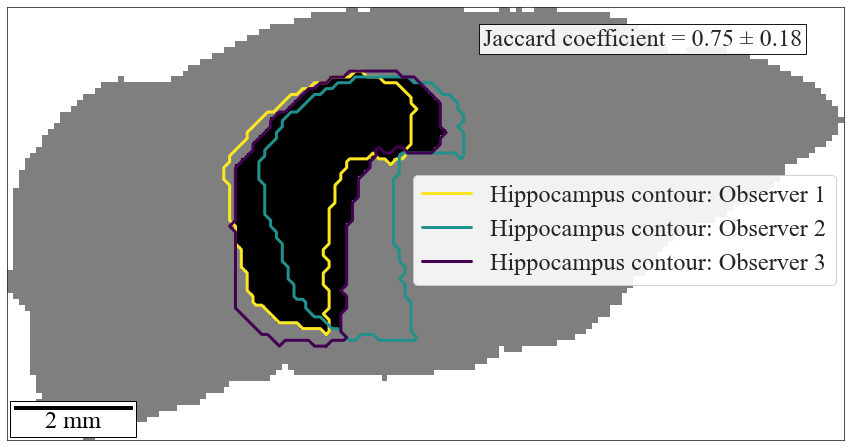

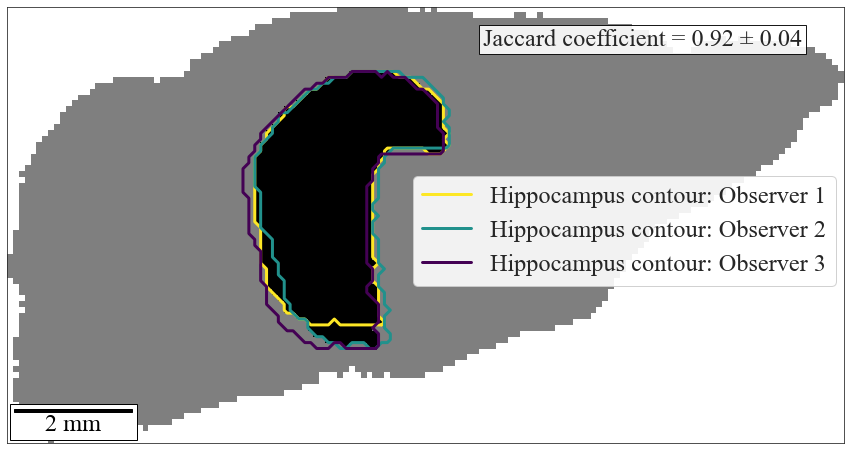

In [56]:
for animal in ['P2E_M14', 'P1_H_C3H_M54']:
    sub = inter_observer[inter_observer['animal'] == animal]
    plan_data = [get_plans(os.path.join(root, animal, f)) for f in sub['filenames']]
    plan_data_fused = fuse_plans(plan_data)

    ax = make_pretty_plan_overlay(plan_data, plan_data_fused)
    ax.figure.savefig(f'./figures/Planning_contour_overlay_interobserver_{animal}')